# Movies Data
### Goal: 

### To measure the correlation between movie ratings of a generic audience and critic ratings

### Data sets
- User rating: *imdb.com* users
- Critic ratings: *rogerebert.com* critics
    
|dataset|#records|notes|
|:--: |:--:|:--:|
|Roger Ebert (https://www.rogerebert.com) |3.5k|contains information about critic rating|
|IMBD (https://www.imdb.com) |6.8k|contains information about audience rating|

---

Since the scope of the applicaiton is to try DC component, and since imputeDB can only impute integer values, I selected the attribute year from *roger_ebert* and I randomly injected ~30 "?" character.

Then, Fahes is employed to discover DMVs, and ImputeDB for the imputetion

---

In [272]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import csv
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn import datasets

In [437]:
'''
{fahes_only} is the dir for results obtained w/o employing ImputeDB
{with_impute} is the dir for results obtained employing ImputeDB

To perfroma the analysis, comment/uncomment the corresponding line
'''

base_path = './data/retults_studio/'
path_in = base_path + "fahes_only/"
path_in = base_path + "with_impute/"
path_out = "./"

path_roger = path_in + "dataset_a.csv"
path_imdb = path_in + "dataset_b.csv"
lableled = path_in + "test_predictions.csv"

In [438]:
# Loading the data
df1 = pd.read_csv(path_roger, encoding = "ISO-8859-1")
df2 = pd.read_csv(path_imdb, encoding = "ISO-8859-1")

# Loading the output of DeepER
df_labeled = pd.read_csv(lableled)

In [439]:
# df_labeled
# DeepER lables all the candidate pairs, with wither 1 or 0 (i.e., match and non-match)
# here we filter only the matches
df_labled_true = df_labeled[df_labeled['gold']==1][['ltable_id','rtable_id']]
df_labled_true.columns = ["id1","id2"]

In [440]:
# number of matches found by DeepER
print('Number of matches found by DeepER:\t\t{}'.format(len(df_labled_true)))
print('Number of comparison executed by DeepER:\t{}'.format(len(df_labeled)))

Number of matches found by DeepER:		296
Number of comparison executed by DeepER:	504


In [441]:
set1 = set(df_labled_true.id1)
set2 = set(df_labled_true.id2)

In [442]:
# joining the two data set using the matching table

partial = pd.merge(df2, df_labled_true, left_on = 'id', right_on = 'id2')
df_ = pd.merge(df1, partial, left_on = 'id', right_on = 'id1')

In [443]:
# renaming cols
colnames = ['id_x', 'movie_name_x', 'year', 'directors', 'aa',
            'critic_rating', 'genre', 'pg_rating', 'duration', 'id_y',
            'movie_name_y', 'directorss', 'actors', 'movie_rating', 'genres',
            'dd', 'id1', 'id2']

In [444]:
df_.columns = colnames
df_join = df_.drop(['id1', 'id2'], axis=1)

In [510]:
# fueature selected
cc = [
    'critic_rating', # from roger
    'pg_rating',
    'year', # from roger, imputed (or null)
    'duration',
    'actors',
    'movie_rating' # from imdb
     ]

In [511]:
movies = df_join[cc]
movies = movies.dropna()

## User rating vs. Critic Rating (Pearson correlation)

In [512]:
import numpy
#corr = numpy.corrcoef(movies['movie_rating'], movies['critic_rating'])
#corr

In [513]:
dd = movies[['movie_rating','critic_rating']]

In [514]:
correlations = dd.corr()
correlations

,movie_rating,critic_rating
movie_rating,1.000000,0.481381
critic_rating,0.481381,1.000000


## Visualization

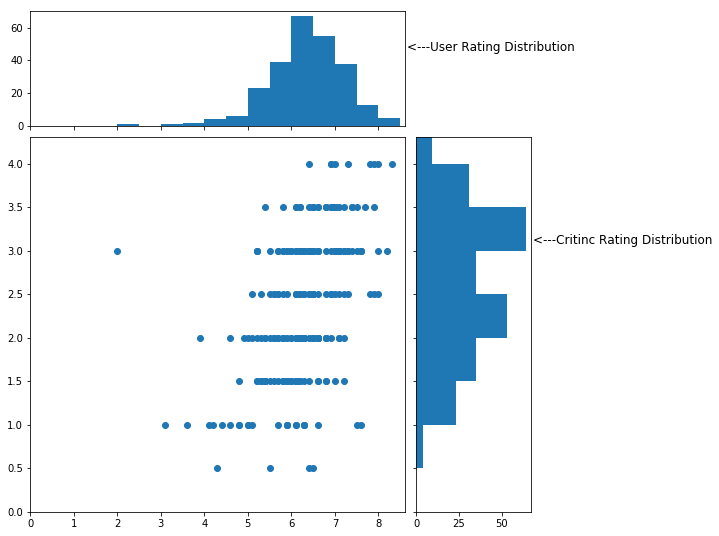

In [515]:
from matplotlib.ticker import NullFormatter

# the random data
x = dd.movie_rating.values
y = dd.critic_rating.values

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.5
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((0, max(dd.movie_rating)+0.3))
axScatter.set_ylim((0, max(dd.critic_rating)+0.3))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axHistx.set_title("<---User Rating Distribution", rotation=0,  x=1.23, y=0.6 )
axHisty.set_title("<---Critinc Rating Distribution",rotation=0,  x=1.79, y=0.7)

plt.show()

In [516]:
print('Max critic rating:\t{}'.format(max(dd.critic_rating)))
print('Max user rating:\t{}'.format(max(dd.movie_rating)))

Max critic rating:	4.0
Max user rating:	8.3


In [524]:
mm = movies.copy()

In [525]:
ml = mm#[mm.critic_rating>1.5]

## Movie rating Prediction

In [526]:
X = ml.drop('movie_rating',axis=1)
Y = ml[['movie_rating']]

X = pd.get_dummies(X)

In [527]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [528]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [529]:
regression_model.score(X_test, Y_test)

0.315539454668742